### Quick Summary on Temperature Option Features
Underlying: HDD/CDD index over given period. 

The underlying of a temperature option is the heating/cooling degree days (HDD/CDD) index based on ‘approximation’ of average temperature and reference temperature.
<ol>
<li> Temperature Underlying 
$\large T_n = \frac{T^{max}+T^{min}}{2}$
<li> Degree Days
For a day $n∈N$:
$\large HDD_n = (T_{ref}-T_n)^+ \\ \large CDD_n = (T_n – T_{ref})^+$
<li> Payoff Functions
Here the buyer of an option with receive an amount:
$\large \xi = f(DD)$
Payoff function f is computed on the cumulative index over a period P:
<ul>
   <li> heating degree seasons $DD = H_n = HDD^{N} = \sum^N_n HDD_n$
   <li> cooling degree seasons $DD = C_n = CDD^{N} = \sum^N_n CDD_n$
</ul>
<li> Typical Seasons OTC
<ul>
 <li>CDD season: MAY-SEP STRIP JUL-AUG STRIP

  <li>HDD season: DEC-FEB STRIP and NOV-MAR STRIP
</ul>
<li> Popular Payoff Functions
Call with Cap
$\large \xi = min\{\alpha(DD – K)^+, C\}$
where:
<ul>
 <li> payoff rates $\alpha$ is commonly $\$2,500$ or $\$5,000$
 <li> while caps $C$ is commonly $\$500,000$ or $\$1,000,000$
</ul>

# Temperature Derivative Pricing
For this project we focus on temperatures about Texas, particularly Dallas, TX as CME provides temperature options for us to compare empirically. https://www.cmegroup.com/trading/weather/.

For information regarding HDD and CDD: https://www.eia.gov/energyexplained/units-and-calculators/degree-days.php
Temperature dating is coming from Meteostat library and default is Celsius, more info here :https://dev.meteostat.net/python/

In [63]:
# Import Meteostat library and dependencies
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import numpy as np
import pandas as pd

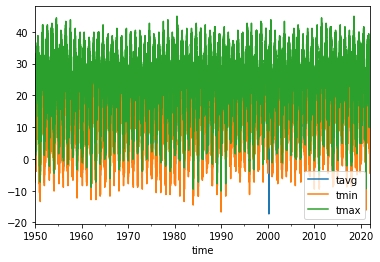

In [64]:
# Temps Data is in Celsius
# Set time period
start = datetime(1950, 1, 1)
end = datetime(2022, 1, 1)

# Create Point for Dallas
dallas = Point(32.7767, -96.7970, 70)

# Get daily data from 1950 to 2022
data = Daily(dallas, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

In [65]:
tempData = data[["tmin","tmax","tavg"]]

Our goal is to identify any missing values in the dataset. Surprisingly, we discovered that there are 3100 null values for the variable "tavg", whereas no null values were found for "tmin" and "tmax". Instead of discarding the affected rows, we can compute the average value and use it to fill in the null values.

In [66]:
tempData.isnull().value_counts()

tmin   tmax   tavg 
False  False  False    23199
              True      3100
dtype: int64

In [67]:
tempData

,tmin,tmax,tavg
time,,,
1950-01-01,13.8,18.8,16.0
1950-01-02,17.7,22.7,19.8
1950-01-03,-0.1,24.4,21.8
1950-01-04,-7.3,-0.1,-2.4
1950-01-05,-5.6,-1.7,-4.7
...,...,...,...
2021-12-28,14.4,27.7,22.7
2021-12-29,13.3,23.8,18.4
2021-12-30,8.8,24.9,16.1


In [68]:
tempData['tavg'] = tempData[["tmin", "tmax"]].mean(numeric_only=True, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
tempData.describe()

,tmin,tmax,tavg
count,26299.000000,26299.000000,26299.000000
mean,14.392623,25.538910,19.965767
std,9.154443,9.373406,9.073823
min,-16.700000,-10.100000,-12.300000
25%,6.600000,19.400000,13.000000
50%,15.500000,26.600000,21.050000
75%,22.700000,33.300000,27.750000
max,31.600000,44.900000,38.000000


In [70]:
# Summer in Texas extends from May to September
temps_season = tempData.copy(deep=True)
temps_season['month'] = temps_season.index.month
mask = (temps_season['month'] >= 5) & (temps_season['month'] <= 10)
temps_season['summer'] = np.where(mask,1,0)
temps_season['winter'] = np.where(temps_season['summer'] != 1,1,0)
temps_season

,tmin,tmax,tavg,month,summer,winter
time,,,,,,
1950-01-01,13.8,18.8,16.30,1,0,1
1950-01-02,17.7,22.7,20.20,1,0,1
1950-01-03,-0.1,24.4,12.15,1,0,1
1950-01-04,-7.3,-0.1,-3.70,1,0,1
1950-01-05,-5.6,-1.7,-3.65,1,0,1
...,...,...,...,...,...,...
2021-12-28,14.4,27.7,21.05,12,0,1
2021-12-29,13.3,23.8,18.55,12,0,1
2021-12-30,8.8,24.9,16.85,12,0,1


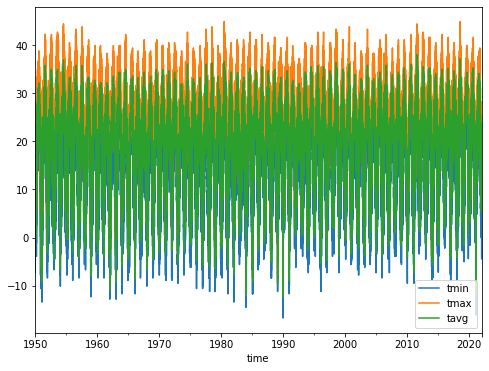

In [71]:
tempData[:].plot(figsize=(8,6))
plt.show()

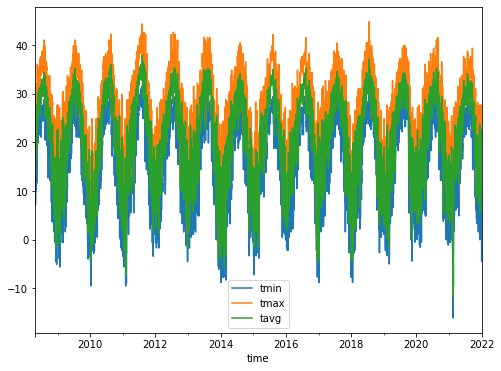

In [72]:
# zooming in on above
tempData[-5000:].plot(figsize=(8,6))
plt.show()

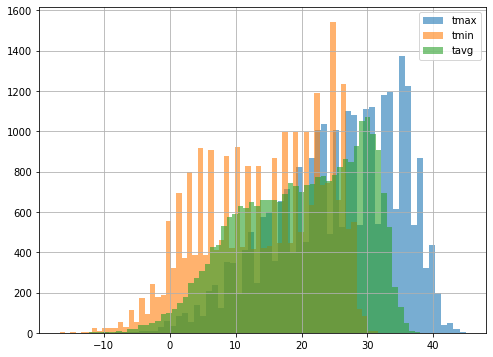

In [73]:
#Temperature Distributions
plt.figure(figsize=(8,6))
tempData.tmax.hist(bins=60, alpha=0.6, label='tmax')
tempData.tmin.hist(bins=60, alpha=0.6, label='tmin')
tempData.tavg.hist(bins=60, alpha=0.6, label='tavg')
plt.legend()
plt.show()

NOTE: Temperature Data is in degrees Celsius.
Texas is typically warm so slight skew to right

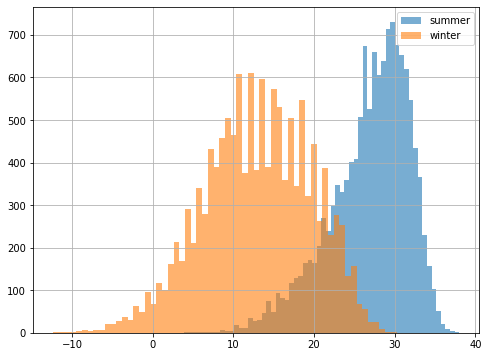

In [74]:
plt.figure(figsize=(8,6))
temps_season[temps_season['summer'] == 1]['tavg'].hist(bins=60, alpha=0.6, label='summer')
temps_season[temps_season['winter'] == 1]['tavg'].hist(bins=60, alpha=0.6, label='winter')
plt.legend()
plt.show()

Interesting to note that the summer temperatures are clearly positively skewed where as the winter temperatures appear more normal with a slight positive skew. 

In [75]:
date_list = tempData.index.tolist()
# MS means Monthly Starts
# We are aggreagating data into a table by month and then finding max_max, max_min, min_max, min_min within those months
mth_temps = pd.DataFrame(data=date_list, index=date_list).resample('MS')[0].agg([min, max])
mth_temps['month'] = mth_temps.index.month
def min_max_temps(row):
    stats = tempData[(tempData.index >= row['min']) & (tempData.index <= row['max'])].agg([min, max])
    row['Tmax_max'] = stats.loc['max', 'tmax']
    row['Tmax_min'] = stats.loc['min', 'tmax']
    row['Tmin_max'] = stats.loc['max', 'tmin']
    row['Tmin_min'] = stats.loc['min', 'tmin']
    row['Tavg_max'] = stats.loc['max', 'tavg']
    row['Tavg_min'] = stats.loc['min', 'tavg']
    return row

mth_temps = mth_temps.apply(min_max_temps,axis=1)
mth_temps

mth_temps.head()

,min,max,month,Tmax_max,Tmax_min,Tmin_max,Tmin_min,Tavg_max,Tavg_min
1950-01-01,1950-01-01,1950-01-31,1,28.3,-1.7,19.4,-7.3,23.55,-3.70
1950-02-01,1950-02-01,1950-02-28,2,27.7,1.6,13.3,-0.6,19.65,0.50
1950-03-01,1950-03-01,1950-03-31,3,31.1,6.1,21.6,-3.9,26.05,1.35
1950-04-01,1950-04-01,1950-04-30,4,33.3,13.3,19.4,2.7,24.95,11.05
1950-05-01,1950-05-01,1950-05-31,5,34.9,21.1,23.8,13.3,28.30,17.75


In [76]:
grouped_mths = mth_temps.groupby(mth_temps.month)[['Tmax_max', 'Tmax_min', 'Tmin_max', 'Tmin_min','Tavg_max','Tavg_min']].agg([min, max])
grouped_mths['months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouped_mths = grouped_mths.set_index('months')
grouped_mths[[('Tmax_max', 'max'),('Tmin_min', 'min'),('Tmax_min', 'min'),('Tmin_max', 'max')]]

,Tmax_max,Tmin_min,Tmax_min,Tmin_max
,max,min,min,max
months,,,,
Jan,31.6,-13.4,-8.9,20.5
Feb,35.5,-16.1,-9.4,21.1
Mar,36.6,-8.4,-1.7,22.7
Apr,38.3,-0.1,6.6,24.4
May,39.9,4.4,12.2,27.2
Jun,44.9,12.2,18.3,31.6
Jul,44.9,16.1,24.4,31.6
Aug,44.4,15.5,22.2,31.6


In [77]:
#Temperature derivatives are based on average temp so lets inspect futher
grouped_mths[[('Tavg_max', 'max'),('Tavg_max', 'min'),('Tavg_min', 'max'),('Tavg_min', 'min')]]

Tavg_max        Tavg_min       
            max    min      max    min
months                                
Jan       23.55   9.70     9.70 -10.85
Feb       25.20  13.00     8.25 -11.60
Mar       27.45  18.25    12.70  -5.05
Apr       30.25  23.30    17.15   3.25
May       32.70  25.80    21.85  10.25
Jun       36.60  29.65    27.75  17.20
Jul       37.15  30.50    31.90  21.35
Aug       38.00  30.80    30.25  19.40
Sep       36.05  27.45    26.60  12.70
Oct       31.10  24.40    18.30   3.85
Nov       28.55  18.85    11.05  -2.25
Dec       24.40  13.25     5.80 -12.30

### Before we can price the derivative we want to model the underlying. The underlying of temperature options are degree days (DD) which in turn are determined by average temp. So we want to model average temp.

# Linear Decomposition (Time Series Modeling)

In [78]:
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults

In [79]:
tempData.sort_index(inplace=True)
tempData

,tmin,tmax,tavg
time,,,
1950-01-01,13.8,18.8,16.30
1950-01-02,17.7,22.7,20.20
1950-01-03,-0.1,24.4,12.15
1950-01-04,-7.3,-0.1,-3.70
1950-01-05,-5.6,-1.7,-3.65
...,...,...,...
2021-12-28,14.4,27.7,21.05
2021-12-29,13.3,23.8,18.55
2021-12-30,8.8,24.9,16.85


<AxesSubplot:title={'center':'Rolling mean over annual periods'}, xlabel='time'>

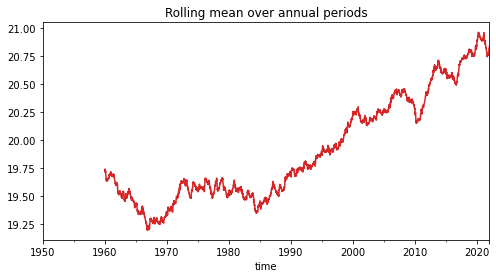

In [80]:
tempData['tavg'].rolling(window = 365*10).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean over annual periods")

We can see a clear upward trend in the mean

<AxesSubplot:title={'center':'Rolling variance over annual periods'}, xlabel='time'>

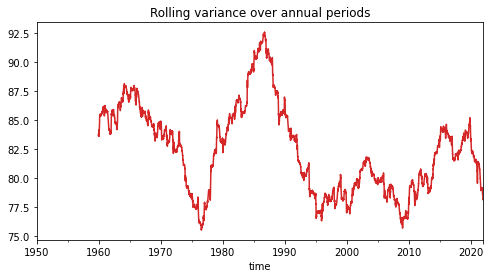

In [81]:
tempData['tavg'].rolling(window = 365*10).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over annual periods")

The variance is also changing over time 

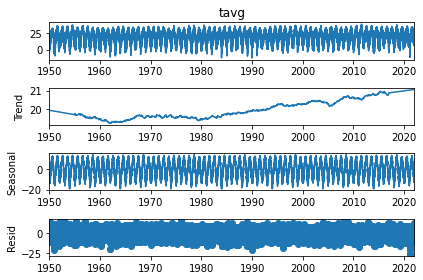

In [82]:
decompose_result = seasonal_decompose(tempData['tavg'], model='additive', period=int(365*10), extrapolate_trend='freq')

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

### Visualise All Data
decompose_result.plot()
plt.show()

Note: We used a 10 year period to smooth out the trend which in turn passes more of the variability into the seasonal/residual components

(-20.0, 20.0)

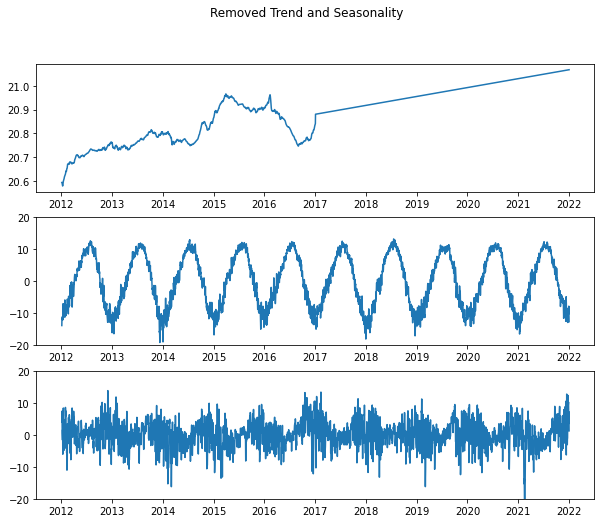

In [83]:
### Visualise 10 years
years_examine = 365*10
fig, axs = plt.subplots(3, figsize=(10,8))
fig.suptitle('Removed Trend and Seasonality')
axs[0].plot(trend[-years_examine:])
axs[1].plot(seasonal[-years_examine:])
axs[1].set_ylim([-20,20])
axs[2].plot(residual[-years_examine:])
axs[2].set_ylim([-20,20])

## Testing for Stationarity with Dicky-Fuller
### Unit Root Test, null hypothesis is that unit root exists.

In [84]:
dftest = adfuller(residual, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -23.20187131655861
2. P-Value :  0.0
3. Num Of Lags :  31
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 26267
5. Critical Values :
	 1% :  -3.430598979295996
	 5% :  -2.861650041544481
	 10% :  -2.566828571855951


<AxesSubplot:>

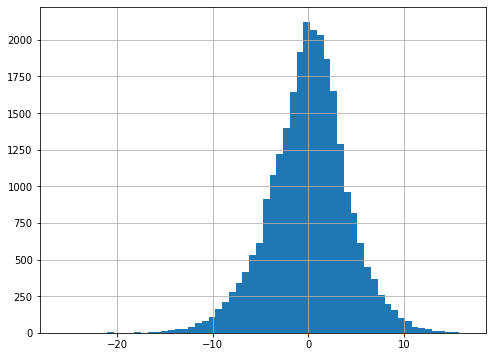

In [85]:
residual.hist(bins=60, figsize=(8,6))

We can reject the null and state the residuals are stationary. Clearly we were able to see some sort of auto correlation, so we want to plot the ACF as shown below:

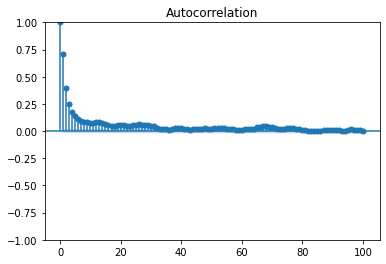

In [86]:
plot_acf(residual, lags=100)
plt.show()

Above we can see significant serial correlation. Since the auto-correlation funtion does not seem to vanish after after a finite number of lags, we do not try and fit a moving average model.

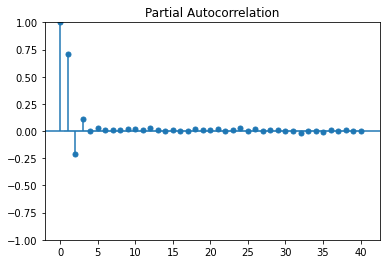

In [87]:
# ywm Yule-Walker
plot_pacf(residual, lags=40, method='ywm')
plt.show()

AIC is a single number score that can be used to determine which of multiple models is most likely to be the best model for a given dataset. AIC works by evaluating the model’s fit on the training data, and adding a penalty term for the complexity of the model.

𝐴𝐼𝐶$=−2\ln(𝐿)+2𝑘$
AIC equation, where $L :=$ likelihood and $k :=$ # of parameters. AIC uses a model’s maximum likelihood estimation 𝑙𝑜𝑔−𝑙𝑖𝑘𝑒𝑙𝑖ℎ𝑜𝑜𝑑 as a measure of fit. Log-likelihood is a measure of how likely one is to see their observed data, given a model. The model with the maximum likelihood is the one that “fits” the data the best.

The desired result is to find the lowest possible AIC, which indicates the best balance of model fit with generalizability. This serves the eventual goal of maximizing fit on out-of-sample data.

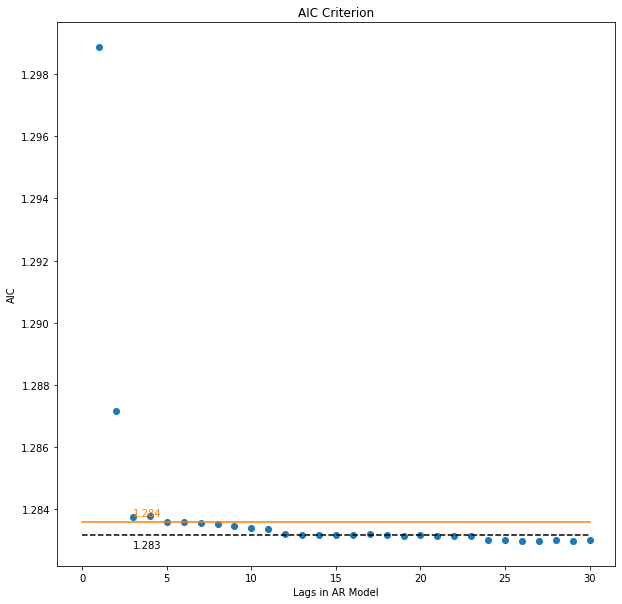

In [88]:
residuals = residual.copy(deep=True)
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

mod = ar_select_order(residuals, maxlag=30, ic='aic')

aic = []
for key, val in mod.aic.items():
    if key != 0:
        aic.append((key[-1], val))

aic.sort()    
x,y = [x for x,y in aic],[y/100000 for x,y in aic]

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot([0,30],[y[5],y[5]], 'tab:orange')
plt.text(3,y[5]+0.0002, '{0}'.format(round(y[5],3)),color='tab:orange')
plt.plot([0,30],[y[12],y[12]], 'k--')
plt.text(3,y[12]-0.0004, '{0}'.format(round(y[12],3)))
plt.title("AIC Criterion")
plt.xlabel("Lags in AR Model")
plt.ylabel("AIC")
plt.show()

Not much difference from lag 5 to lag 12, will stick with fitting a AR of lags=5

In [89]:
# We use trend='n' to remove intercept from model
model = AutoReg(residuals, lags=5,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                26299
Model:                     AutoReg(5)   Log Likelihood              -64259.292
Method:               Conditional MLE   S.D. of innovations              2.787
Date:                Sun, 02 Apr 2023   AIC                         128530.584
Time:                        14:19:08   BIC                         128579.646
Sample:                    01-06-1950   HQIC                        128546.425
                         - 01-01-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid.L1       0.8824      0.006    143.130      0.000       0.870       0.894
resid.L2      -0.3094      0.008    -37.635      0.000      -0.326      -0.293
resid.L3       0.1196      0.008     14.229      0.0

All P values are zero, indicating we rejec the null and that all 5 coefficients are statistically significant.

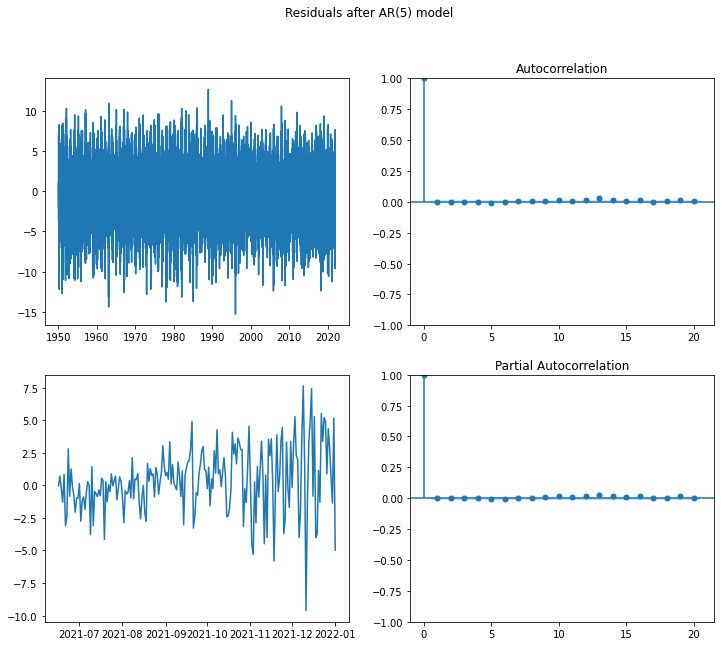

In [90]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Residuals after AR(5) model')
#plot all residuals
axs[0,0].plot(res)
# zoom in and plot last 200 residuals
axs[1,0].plot(res[-200:])
plot_acf(res, lags=20, ax=axs[0,1])
plot_pacf(res, lags=20, ax=axs[1,1])
plt.show()

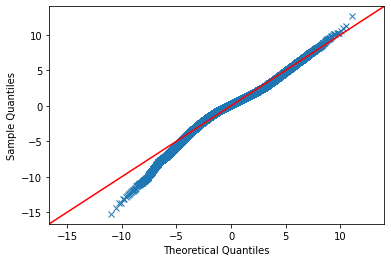

In [91]:
from scipy.stats import norm
qqplot(res, marker='x', dist=norm, loc=0, scale=np.std(res), line='45')
plt.show()

The serial correlation in the data appears to have been captured by the AR5 model. We have our classical linear decomposition model, including the trend, seasonality and AR5 model.

# De-trending and modelling seasonal variation with Fourier Series

The temperature data has an obvious sinusoidal pattern to it making it a possible target for fourier series modeling. However, we want to denoise the series to see overall trend and peaks.

Convolutions are often used in signal processing for denoise signals.
A convolution is a mathematical operation which generates a new function that is a function of two prior functions, meaning the convolution is the area under the curve of the two functions which are moved towards and away from one another ‘𝑐𝑜𝑛𝑣𝑜𝑙𝑣𝑒𝑑′.

$(𝑓∗𝑔)(𝑥)=\int_{-\infty}^{\infty}𝑓(𝜏)𝑔(𝑥−𝜏)𝑑𝜏$

In [92]:
from scipy import signal

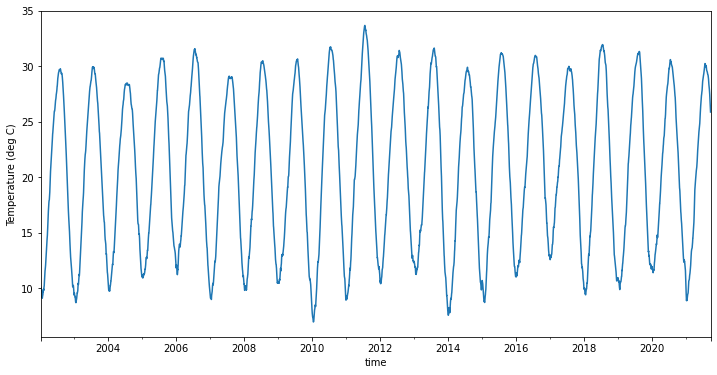

In [93]:
lookback = 365*20
# low-pass window filter is used for simplicity
def apply_convolution(x, window):
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(x, conv, mode='same') / window
    return filtered

denoised = tempData.apply(lambda x: apply_convolution(x, 90))
denoised['tavg'][-lookback:-100].plot(figsize=(12,6))
plt.ylabel('Temperature (deg C)')
plt.show()

<AxesSubplot:title={'center':'Rolling mean over annual periods'}, xlabel='time', ylabel='Temperature (deg C)'>

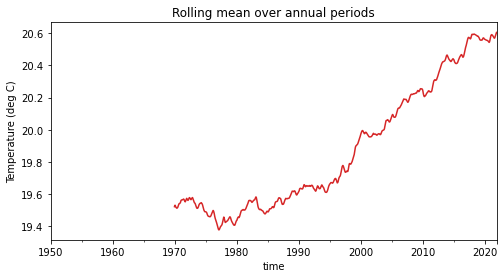

In [94]:
denoised['MA'] = denoised['tavg'].rolling(window = lookback).mean()
plt.ylabel('Temperature (deg C)')
denoised['MA'].plot(figsize=(8,4), color="tab:red", title="Rolling mean over annual periods")

Observing the rolling moving average over time, it is clear that there is a long term trend over time. However it is fairly weak. We will simply use the following linear function: $𝑇𝑙𝑖𝑛𝑒𝑎𝑟=\alpha+\beta 𝑡$

The seasonal variation of the denoised temperature time series is sinusoidal and has somewhat uniform peaks

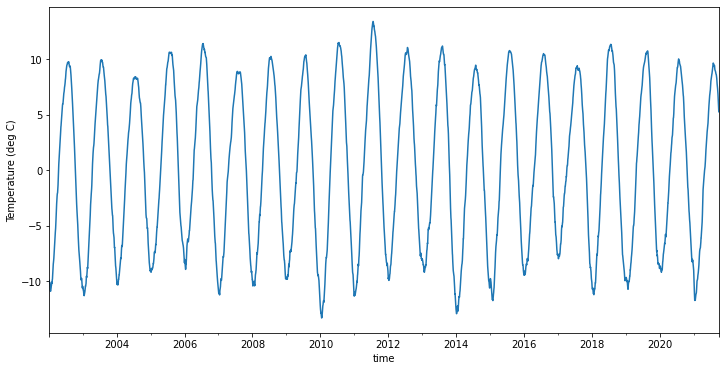

In [95]:
denoised['S'] = denoised['tavg'] - denoised['MA']
denoised['S'][-lookback:-100].plot(figsize=(12,6))
plt.ylabel('Temperature (deg C)')
plt.show()

We will model the seasonal variation via a truncated Fourier series of form:

$𝑇_{seasonal}= a_0 + \sum_{i} a_i sin(i\omega_1t + \theta) + \sum_{i} b_i cos(i\omega_2t + \phi)$

Because the peaks and troughs are close to uniform as well as constant wavelengths, we can actually simplify this to a first order fourier series:
$𝑇_{seasonal}= a sin(\omega t + \theta) + b cos(\omega t + \theta)$

We want to keep our model as simple as possible and avoid overfitting so it is worth comparing the above model to the simplist possible first order model:
$𝑇_{seasonal}= a sin(\omega t + \theta)$

We can expand this further to:
$𝑇_{seasonal}= a sin(\theta)cos(\omega t) + a cos(\theta)sin(\omega t)$

Where we can define $a_1 = a sin(\theta)$ and $b_1 = a cos(\theta)$.
To get $𝑇_{seasonal}= a_1 cos(\omega t) + b_1 sin(\omega t)$.
And $a = \sqrt{(a_1)^2+(b_1)^2}$ and $\theta = arctan(\frac{a_1}{b_1})$

Note:
$a_0$ of the fourier series will be captured in the trend component.

### Testing the two denoised time series models

So $𝑇=𝑇𝑡𝑟𝑒𝑛𝑑+𝑇𝑠𝑒𝑎𝑠𝑜𝑛𝑎𝑙$
Two Models:
<ol>
    <li>$a + bt + \alpha sin(\omega t + \theta) + \beta cos(\omega t + \theta)$
    <li>$a + bt +\alpha sin(\omega t + \theta)$

We want to compare non-linear model fits, so we need non-linear least squares: https://stackoverflow.com/questions/23004374/how-to-calculate-the-likelihood-of-curve-fitting-in-scipy.

Here we use scipy.optimize.curve_fit which allows us to implement the "Levenberg-Marquardt" algorithm.
This is used in non-linear least squares problems and combines both the Gauss-Newton algorithm with gradient descent method to speed up convergence.

$\beta \in argmin_{\beta}𝑆(\beta) \equiv argmin_{\beta}\sum_{i-1}^{N}[y_i–f(x_i,\beta)]^2$

In [96]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [97]:
temp_t = tempData['tavg'].copy(deep=True)
temp_t = temp_t.to_frame()

def model_fit_general(t, a, b, a1, b1, theta, phi):
    omega = 2*np.pi/365.25
    y_pred = a + b*t + a1*np.cos(omega*t + theta) + b1*np.sin(omega*t + phi)
    return y_pred

def model_fit(t, a, b, a1, b1):
    omega = 2*np.pi/365.25
    y_pred = a + b*t + a1*np.cos(omega*t) + b1*np.sin(omega*t)
    return y_pred

def RSS(y, y_pred):
    return np.sqrt( (y - y_pred)**2 ).sum()

# check to see if pd.DatetimeIndex object
if isinstance(temp_t.index , pd.DatetimeIndex):
    # datetime.toordinal() is a simple method used to manipulate the objects of DateTime class. 
    # It returns proleptic Gregorian ordinal of the date, where January 1 of year 1 has ordinal 1. 
    # Each time instance is a new day hence we want ordinal. Consequently our wave speed omega is 2pi / 365.25
    first_ord = temp_t.index.map(datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(datetime.toordinal)
    
params, cov = curve_fit(model_fit, xdata = temp_t.index-first_ord, ydata = temp_t['tavg'], method='lm')

param_list = ['a', 'b', 'a1', 'b1']

print('\n Model 2 / Sine Curve \n') 
std_dev = np.sqrt(np.diag(cov))
for name, p, sd in zip( param_list, params, std_dev):
    print('{0} :  {1:0.3}  CI ~normally [{2:0.2e},{3:0.2e}]'.format(name, p, p-1.96*sd,p+1.96*sd))


 Model 2 / Sine Curve 

a :  19.2  CI ~normally [1.91e+01,1.93e+01]
b :  5.68e-05  CI ~normally [4.98e-05,6.37e-05]
a1 :  -10.8  CI ~normally [-1.09e+01,-1.07e+01]
b1 :  -3.14  CI ~normally [-3.22e+00,-3.07e+00]


In [98]:
temp_t['model_fit'] = model_fit(temp_t.index-first_ord, *params)

if isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(datetime.toordinal)
    
params1, cov1 = curve_fit(model_fit_general, xdata = temp_t.index-first_ord, ydata = temp_t['tavg'], method='lm')

param_list = ['a', 'b', 'a1', 'b1', 'theta', 'phi']

print('\n Model 1 / General First Order Fourier \n') 
std_dev = np.sqrt(np.diag(cov1))
for name, p, sd in zip( param_list, params1, std_dev):
    print('{0} :  {1:0.3}  CI ~normally [{2:0.2e},{3:0.2e}]'.format(name, p, p-1.96*sd,p+1.96*sd))


 Model 1 / General First Order Fourier 

a :  19.2  CI ~normally [1.91e+01,1.93e+01]
b :  5.68e-05  CI ~normally [4.98e-05,6.37e-05]
a1 :  2.71e+02  CI ~normally [-7.68e+06,7.68e+06]
b1 :  2.77e+02  CI ~normally [-7.65e+06,7.65e+06]
theta :  1.08e+02  CI ~normally [-1.32e+04,1.35e+04]
phi :  -4.16e+02  CI ~normally [-1.37e+04,1.29e+04]


Residual Sum of Squares (RSS)
  RSS model generalised: 88349.17
  RSS model sine curve : 88349.2


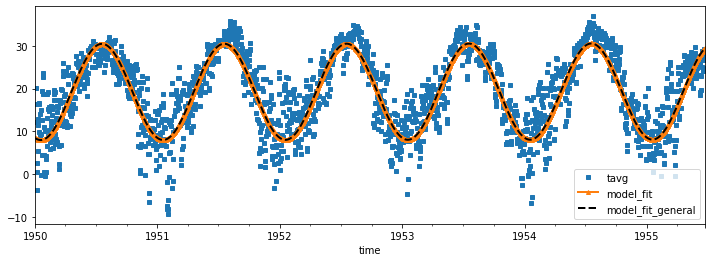

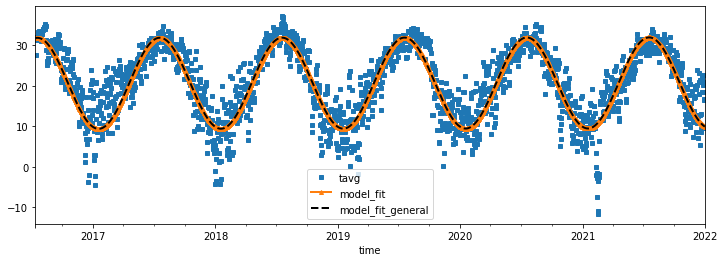

In [99]:
temp_t['model_fit_general'] = model_fit_general(temp_t.index-first_ord, *params1)

if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(datetime.fromordinal)

temp_t[:2000].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )
temp_t[-2000:].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )

RSS(temp_t['tavg'], temp_t['model_fit_general'])
print('Residual Sum of Squares (RSS)')
print('  RSS model generalised:', round(RSS(temp_t['tavg'], temp_t['model_fit_general']),2))
print('  RSS model sine curve :', round(RSS(temp_t['tavg'], temp_t['model_fit']),2))

There is almost no difference in performance of the two, so clearly we want to stick with the simpler sine function.

So our daily average temperature (DAT) model is: 
#### $\bar{T}(t) = 19.2 + 0.0000568t - 11.2472041 sin(\frac{2\pi}{365.25} t + 1.287855763)$

Take a look at the Residuals


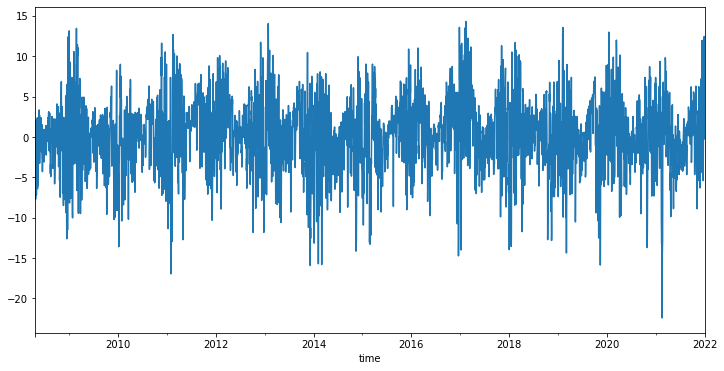

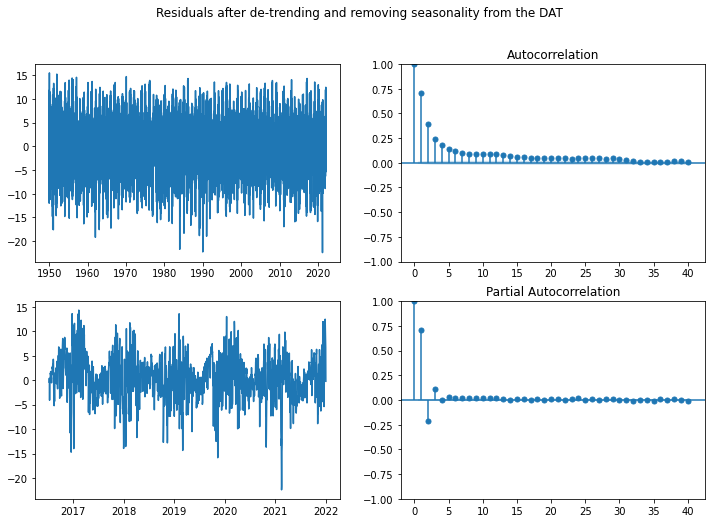

In [100]:
temp_t['res'] = temp_t['tavg']-temp_t['model_fit']
temp_t['res'][-5000:].plot(figsize=(12,6))
plt.show()

fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

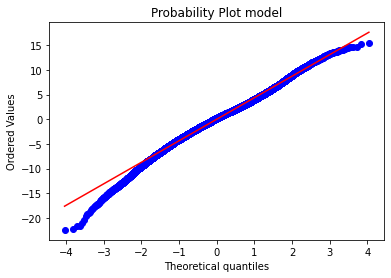

P(Z > 2): 2.45% vs Normal Distibution: 2.28% 
SKEW    : -0.237
KURTOSIS: 3.79


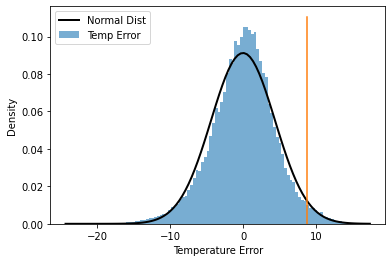

In [101]:
import scipy.stats as stats
stats.probplot(temp_t['res'], dist="norm", plot=plt)
plt.title("Probability Plot model")
plt.show()

mu, std = norm.fit(temp_t['res'])
z = (temp_t['res'] - mu)/std
plt.hist(temp_t['res'], density=True, alpha=0.6, bins=100, label='Temp Error')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
data = np.random.randn(100000)

plt.plot(x, p, 'k', linewidth=2, label='Normal Dist')
plt.plot([std*2,std*2],[0,ymax])

print('P(Z > 2): {:0.3}% vs Normal Distibution: {:0.3}% '.format(len(z[z >= 2])/len(z)*100, (1-norm.cdf(2))*100))
print('SKEW    : {:0.3}'.format(stats.skew(z)))
print('KURTOSIS: {:0.3}'.format(stats.kurtosis(z)+3))
plt.ylabel('Density')
plt.xlabel('Temperature Error')
plt.legend()
plt.show()

We can see the residuals seem to have some seasonality and a slight left skew and larger kurtosis than normal. This non-normal behavior is likely due to extreme temperature deviations.

# Modelling Temperature with a modified Ornstein-Uhlenbeck process

The cyclic nature of temperature supports the use of a mean-reverting dynamics model.
Reference: https://actuaries.asn.au/Library/fsf06_paper_tindall_weather%20derivatives.pdf

It is important that the long run DAT should be $\bar{T}(t)$:
## $\mathbb{E}[T_t] \approx \bar{T_t}$
This is NOT the case with simple OU process. The previous PCF displyed indicates an extra AR(1) term is needed to fully characterize the seasonality of the $\bar{T}(t)$.


Original Work Published by: Doenier & Queruel proposes this extra term can be characterized by adding the term $\frac{\bar{T}_t}{dt}$. So the new modified SDE is now: 
## $dT_t  = [ \frac{d\bar{T}_t}{dt} + k (\bar{T}_t-T_t) ] dt + \sigma_t dW_t$
Instead of using the Ito formula to solve this SDE, this can also be solved with a traditional integrating factor $e^{\int_{0}^{t}k du}$ So we end up woth the following:
### $e^{\int_{0}^{t}k du}d\bar{T}_u - e^{\int_{0}^{t}k du} k(\bar{T}_u-T_u)du + e^{\int_{0}^{t}k du}dT_u = e^{\int_{0}^{t}k du} \sigma_t dW_u \implies$
### $d[e^{\int_{0}^{t}k du} (\bar{T}_u-T_u)] = e^{\int_{0}^{t}k du} \sigma_t dW_u \implies dZ_t = e^{\int_{0}^{t}k du} \sigma_t dW_u$ ; $ Z_t = e^{\int_{0}^{t}k du} (\bar{T}_u-T_u)$
### $\implies Z_t = Z_0 - \int_{0}^{t}e^{\int_{0}^{t}k du} \sigma_t dW_u$
with intial condition:
### $ \bar{T}_0 = T_0 \implies e^{\int_{0}^{t}k du} (\bar{T}_u-T_u) = e^{\int_{0}^{t}k du} (\bar{T}_0-T_0) - \int_{0}^{t}e^{\int_{0}^{t}k du} \sigma_t dW_u \implies$
### $T_t = \bar{T_t} + e^{-\int_{0}^{t}k du}\int_{0}^{t}e^{\int_{0}^{t}k du} \sigma_t dW_u \implies \mathbb{E}[T_t] = \bar{T_t}$

# Estimating Rate of Mean Reversion ($\kappa$)

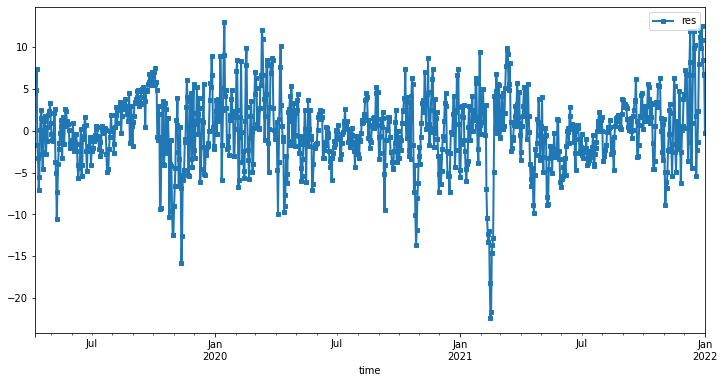

In [102]:
temp_t[['res']][-1000:].plot(figsize=(12,6), style=['s-'] , markersize=4, linewidth=2 )
plt.show()

Discretizing the SDE:
### $T_i-T_{i-1} = \bar{T_i} - \bar{T}_{i-1} +\kappa (\bar{T}_{i-1}-T_{i-1}) + \sigma_i z_i$
Detrend and remove seasonality:
### $\hat{T_t} = T_t - \bar{T}_t$
We want to model as an AR(1) process:
### $\hat{T_i} = \gamma \hat{T}_{i-1} + \sigma_i z_i$ ; $\kappa = 1 - \gamma$

In [103]:
residuals = temp_t['res']
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

model = AutoReg(residuals, lags=1, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
# res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                    res   No. Observations:                26299
Model:                     AutoReg(1)   Log Likelihood              -66962.480
Method:               Conditional MLE   S.D. of innovations              3.087
Date:                Sun, 02 Apr 2023   AIC                         133928.959
Time:                        14:19:37   BIC                         133945.314
Sample:                    01-02-1950   HQIC                        133934.240
                         - 01-01-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res.L1         0.7079      0.004    162.570      0.000       0.699       0.716
                                    Roots                                    
                  Real          Imaginary           M

### $\kappa = 1 - 0.7079 = 0.2921$
So our new OU dynamics is:
### $dT_t  = [ \frac{d\bar{T}_t}{dt} + 0.2921 (\bar{T}_t-T_t) ] dt + \sigma_t dW_t$

# Estimating Time Varying Temperature Volatility ($\sigma_t$)

The volatility estimator is based on the the quadratic variation of of the temperature process $T_t$ 
#### $\Large \hat{\sigma}_t = \sqrt{ \frac{1}{N_t} \sum^{N-1}_{i=0} (T_{i+1} – T_i)^2 }$ 
This could be modeled on a daily basis as with our temperature dynamics or seasonal (monthly / annualy).

In [104]:
temp_t.reset_index(inplace=True)
temp_t['day'] = temp_t['time'].dt.dayofyear
temp_t['month'] = temp_t['time'].dt.month
temp_t['year'] = temp_t['time'].dt.year

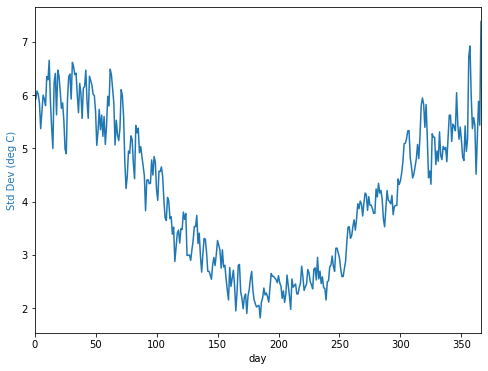

In [105]:
# Daily Volatility
vol = temp_t.groupby(['day'])['tavg'].agg(['mean','std'])
vol['std'].plot(color='tab:blue', figsize=(8,6))
plt.ylabel('Std Dev (deg C)',color='tab:blue')
plt.xlim(0,366) 
plt.show()

## 1. Piece-wise constant functions

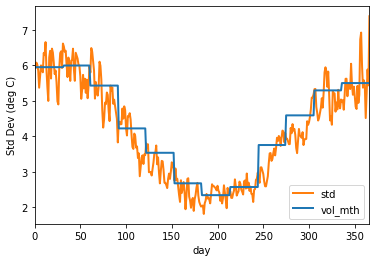

In [106]:
vol_days = temp_t.groupby(['day'])['tavg'].agg(['mean','std'])
vol_mths = temp_t.groupby(['month'])['tavg'].agg(['mean','std'])

vol_days["days"] = vol_days.index
def change_month(row):
    date = datetime(2016, 1, 1) + timedelta(row.days - 1)
    return vol_mths.loc[date.month,'std']

vol_days['vol_mth'] = vol_days.apply(change_month, axis=1)

vol_days[['std', 'vol_mth']].plot(color=['tab:orange','tab:blue'],linewidth=2)
plt.ylabel('Std Dev (deg C)')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()

## 2. Parametric Regression - Polynomials

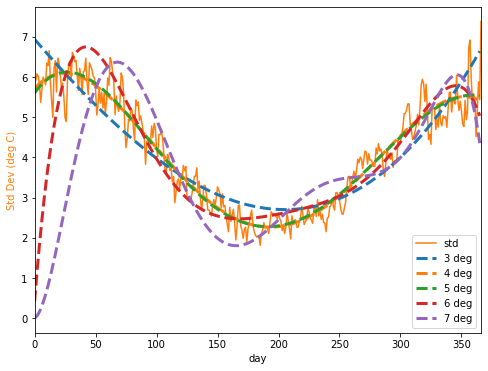

In [107]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# Preprocess x, y combinations to handle dimensionality of Polynomial Features
x = np.array(vol['std'].index)
y = np.array(vol['std'].values)

#Create single dimension
x= x[:,np.newaxis]
y= y[:,np.newaxis]

inds = x.ravel().argsort()  # Sort x values and get index    
x = x.ravel()[inds].reshape(-1,1)
y = y[inds] #Sort y according to x sorted index

# initialise degrees of freedom
poly_feats3 = PolynomialFeatures(degree=3)
poly_feats4 = PolynomialFeatures(degree=4)
poly_feats5 = PolynomialFeatures(degree=5)
poly_feats6 = PolynomialFeatures(degree=6)
poly_feats7 = PolynomialFeatures(degree=7)

# Fit transform to number of polynomial features
xp3 = poly_feats3.fit_transform(x)
xp4 = poly_feats4.fit_transform(x)
xp5 = poly_feats5.fit_transform(x)
xp6 = poly_feats6.fit_transform(x)
xp7 = poly_feats7.fit_transform(x)

# Fit using ordinary least squares
p3 = sm.OLS(y, xp3).fit()
p4 = sm.OLS(y, xp4).fit()
p5 = sm.OLS(y, xp5).fit()
p6 = sm.OLS(y, xp6).fit()
p7 = sm.OLS(y, xp7).fit()

# Predict using original data and model fit
poly3 = p3.predict(xp3)
poly4 = p4.predict(xp4)
poly5 = p5.predict(xp5)
poly6 = p6.predict(xp6)
poly7 = p7.predict(xp7)

vol = temp_t.groupby(['day'])['tavg'].agg(['mean','std'])
vol['std'].plot(color='tab:orange', figsize=(8,6))
plt.plot(poly3, '--', linewidth=3, label='3 deg')
plt.plot(poly4, '--', linewidth=3, label='4 deg')
plt.plot(poly5, '--', linewidth=3, label='5 deg')
plt.plot(poly6, '--', linewidth=3, label='6 deg')
plt.plot(poly7, '--', linewidth=3, label='7 deg')
plt.ylabel('Std Dev (deg C)',color='tab:orange')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()

## Choose Model by Parsimony
Using the Akaike information criterion to judge parsimony between model fit and complexity.
$\Large AIC = 2k – 2ln(\hat{L})$
where $k$ is the numbers of parameters and $\hat{L}$  is the log-likelihood. We will choose 5 parameters because that has the lowest AIC and fits the data best.

In [108]:
p3.aic, p4.aic, p5.aic, p6.aic, p7.aic

(631.4092717165388,
 346.029281262311,
 344.75143302905724,
 956.0927830679019,
 1358.6789652445411)

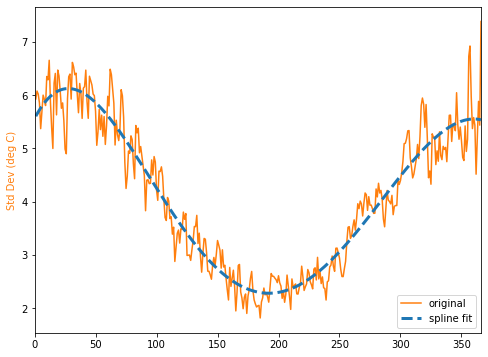

In [109]:
plt.figure(figsize=(8,6))
plt.plot(x, y, color='tab:orange', label='original')
plt.plot(x, poly5, '--', linewidth=3, label='spline fit')
plt.ylabel('Std Dev (deg C)',color='tab:orange')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()

## 3. Local and Nonparametric Regression - Splines

Interpolation is a method of estimating unknown data points in a given range. Spline interpolation is a type of piecewise polynomial interpolation method. Spline interpolation is a useful method in smoothing the curve or surface data.

B-spline curve fitting
B-spline or basis spline is a curve approximation method, and requires the parameters such as knots, spline coefficients, and degree of a spline. To construct a smoother spline fit, we need to specify the number of knots for the target data.
Knots are joints of polynomial segments.

Steps
<ol>
    <li>Based on knots number, we’ll determine the new x data vector by using the quantile function.</li>
    <li>splrep function returns tuple containing the vector of:
        <ul>
            <li>knots
            <li>B-spline coefficients
            <li>degree of the spline
        </ul>
    </li>
</ol>
Use BSpline class to construct spline fit on x vector data.

In [110]:
from scipy import interpolate

x = np.array(vol['std'].index)
y = np.array(vol['std'].values)

knot_numbers = 5
x_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
q_knots = np.quantile(x, x_new) 
t,c,k = interpolate.splrep(x, y, t=q_knots, s=1)
yfit = interpolate.BSpline(t,c,k)(x) 

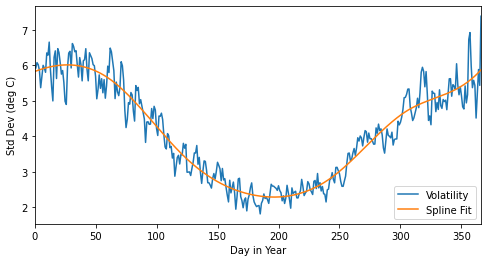

In [111]:
plt.figure(figsize=(8,4))
plt.plot(x, y, label='Volatility')
plt.plot(x, yfit, label='Spline Fit')
plt.ylabel('Std Dev (deg C)')
plt.xlabel('Day in Year')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()

In [112]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1] # Plues two because we need "virtual" points to calculate Bspline
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

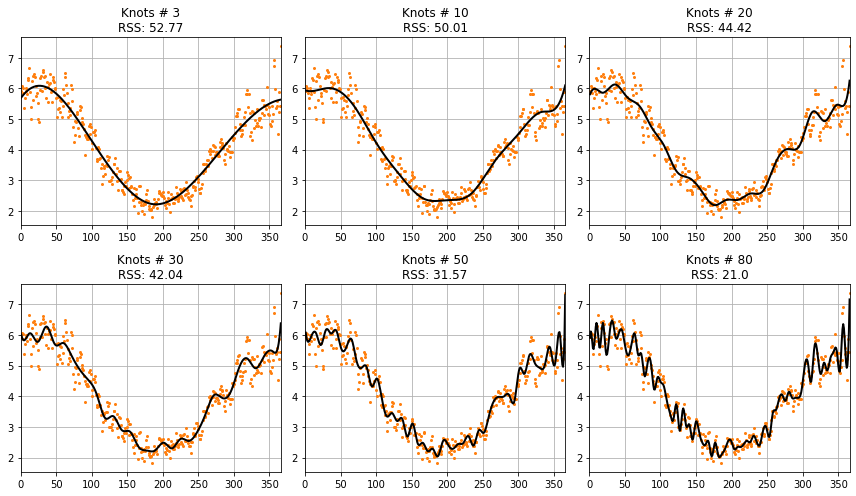

In [113]:
knots = [3, 10, 20, 30, 50, 80]
i = 0

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

for row in range(2):
    for col in range(3):
        ax[row][col].plot(x, y, '.',c='tab:orange', markersize=4)
        yfit = spline(knots[i], x, y)
        rss = np.sum( np.square(y-yfit) )
        ax[row][col].plot(x, yfit, 'k', linewidth=2)
        ax[row][col].set_title("Knots # "+str(knots[i])+"\nRSS: "+str(round(rss,2)), color='k')
        ax[row][col].set_xlim(0,366)
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show() 

## 4. Fourier series to model the volatility of temperature

#### $\Large \sigma_t = a_0 + \sum^I_{i=1} a_i cos(i\omega t) + \sum^J_{j=1} b_j sin(j\omega t)$
Let’s take a look at long term volatility

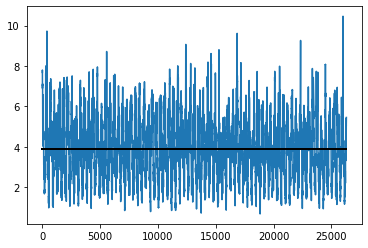

In [59]:
std = temp_t['tavg'].rolling(30).std()

std.plot()
plt.plot([std.index[0], std.index[-1]], [std.mean(),std.mean()], 'k', linewidth=2)
plt.show()
#Note no linear trend so fourier series is okay, if there was the a_0 term would have to be adjusted to vary with time

In [60]:
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    f=2*np.pi/365.25
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')

# Define frequency as yearly
w = 2*np.pi/365.25
model_dict = {y: fourier_series(x, f=w, n=3)} # 3rd Order Model
print('Example of Fourier Model \n', model_dict)

if isinstance(std.index , pd.DatetimeIndex):
    first_ord = std.index.map(dt.datetime.toordinal)[0]
    std.index=std.index.map(dt.datetime.toordinal)

time_mask = -int(30*365.25)

# Make step function data
xdata = std.index[time_mask:] - first_ord
ydata = np.array(std[time_mask:])

Example of Fourier Model 
 {y: a0 + a1*cos(0.0172024238389585*x) + a2*cos(0.034404847677917*x) + a3*cos(0.0516072715168755*x) + b1*sin(0.0172024238389585*x) + b2*sin(0.034404847677917*x) + b3*sin(0.0516072715168755*x)}


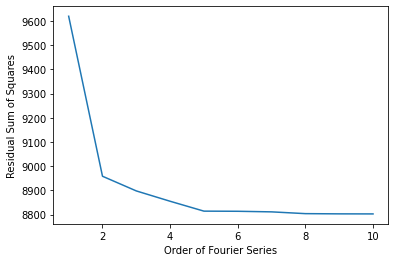

In [61]:
rss = []
for fourier_order in range(1,11):
    model_dict = {y: fourier_series(x, f=w, n=fourier_order)}
    
    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()
    rss.append(fit_result.chi_squared)
    
plt.plot(range(1,11),rss)
plt.ylabel('Residual Sum of Squares')
plt.xlabel('Order of Fourier Series')
plt.show()

Fourier Series Parameters:
a0 3.771
a1 1.23
a2 -0.096
a3 -0.079
a4 0.013
a5 0.041
b1 1.083
b2 -0.334
b3 -0.069
b4 -0.087
b5 0.076


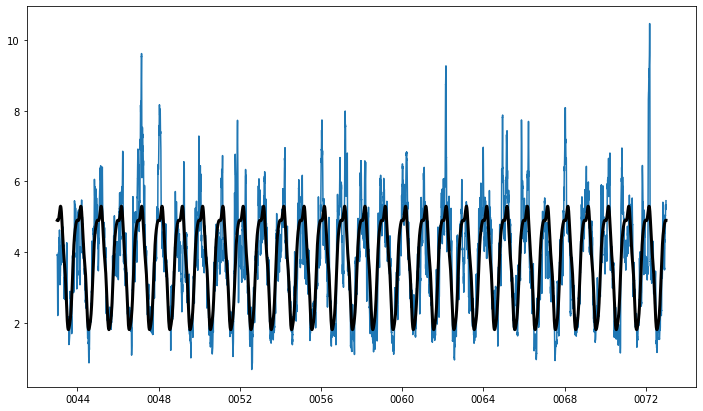

In [67]:
# We will use order 5
model_dict = {y: fourier_series(x, f=w, n=5)}

# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()

# Map back to datetime from ordinal
xdata2=(xdata+first_ord).map(datetime.fromordinal)

# Plot the result
plt.figure(figsize=(12, 7))
plt.plot(xdata2, ydata)
plt.plot(xdata2, fit.model(x=xdata, **fit_result.params).y, 'k-', linewidth=3)

print("Fourier Series Parameters:")
for i,v in fit_result.params.items():
    print(i,round(v,3))

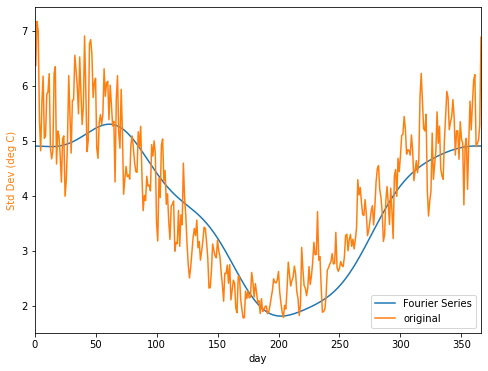

In [92]:
fourier = pd.DataFrame({'date':xdata2, 
                        'volatility':ydata,
                        'model':fit.model(x=xdata, **fit_result.params).y})
fourier['day'] = fourier['date'].apply(lambda x: x.timetuple().tm_yday)
fourier.index = fourier.date
fourier = fourier.drop(columns='date')
fourier_model = fourier.groupby(['day'])['model'].agg(['mean','std'])
vol = temp_t[time_mask:].groupby(['day'])['tavg'].agg(['mean','std'])
x = np.array(vol['std'].index)
y = np.array(vol['std'].values)
fourier_model['mean'].plot(color='tab:blue', figsize=(8,6), label='Fourier Series')
plt.ylabel('Std Dev (deg C)',color='tab:orange')
plt.plot(x, y, color='tab:orange', label='original')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()

## 5. Stochastic Differential Equation
$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.2921 (\bar{T_t} – T_t)\right]dt + \sigma_t dW_{1,t} \\$
$\large d\sigma_t = k_\sigma (\bar{\sigma_t} – \sigma_t)dt + \gamma_t dW_{2,t}$

Trend or long term volatility is easy: ~ 3.924


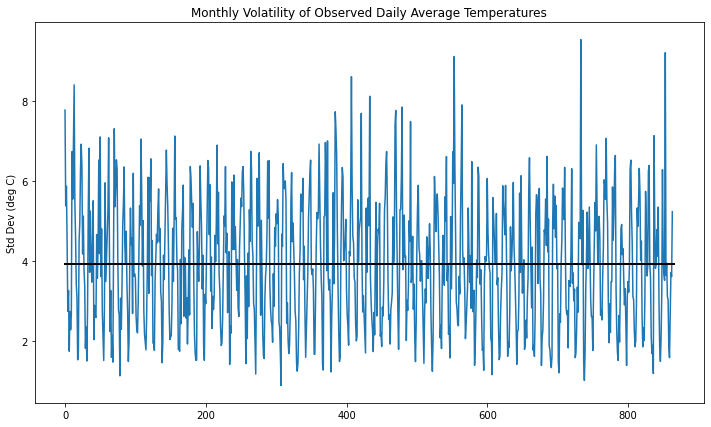

In [94]:
vol = temp_t.groupby(['year','month'])['tavg'].agg(['mean','std'])
vol = vol.reset_index()

vol['std'].plot(figsize=(12,7))
plt.plot([0, len(vol)], [vol['std'].mean(),vol['std'].mean()], 'k', linewidth=2)
plt.ylabel('Std Dev (deg C)')
plt.title('Monthly Volatility of Observed Daily Average Temperatures', color='k',)
print('Trend or long term volatility is easy: ~', round(vol['std'].mean(),3))
plt.show()

Estimating volatility of volatility process using the estimator presented in Alaton et al.

The volatility estimator is based on the the quadratic variation of the volatility process $\sigma_t$
$ \\ \Large \hat{\gamma_t} = \sqrt{ \frac{1}{N_t} \sum^{N-1}_{i=0} (\sigma{i+1} – \sigma_i)^2 }$

In [108]:
print('Gamma is: ', round(vol['std'].std(),3))
model = AutoReg(vol['std'], lags=1, old_names=True,trend='n', missing='drop')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
print('Rate of mean reversion of volatility process is : ', coef[0])
print(model_fit.summary())

Gamma is:  1.574
Rate of mean reversion of volatility process is :  0.9379379986242836
                            AutoReg Model Results                             
Dep. Variable:                    std   No. Observations:                  864
Model:                     AutoReg(1)   Log Likelihood               -1546.776
Method:               Conditional MLE   S.D. of innovations              1.453
Date:                Sun, 02 Apr 2023   AIC                           3097.551
Time:                        10:51:23   BIC                           3107.072
Sample:                             1   HQIC                          3101.196
                                  864                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
std.L1         0.9379      0.012     80.166      0.000       0.915       0.961
                                    Roots   

So our final 2-factor modified OU model is:
#### $\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.2921 (\bar{T_t} – T_t)\right]dt + \sigma_t dW_{1,t}$
#### $\large d\sigma_t = 0.938 (3.924 – \sigma_t)dt + 1.574 dW_{2,t}$

# Monte Carlo Simulation of Temperature for Weather Derivative Pricing

Recall that $\sigma_t$ models temperature volatility at a monthly granularity where as $dT_t$ is at a daily granularity.
So path simulations must follow accordingly.

For temperature path simulation, we will be using the 1 factor modified OU dynamics for temperature:
#### $\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.2921 (\bar{T_t} – T_t)\right]dt + \sigma_t dW_{1,t}$
Along with a 5 knot BSpline model for daily volatility:

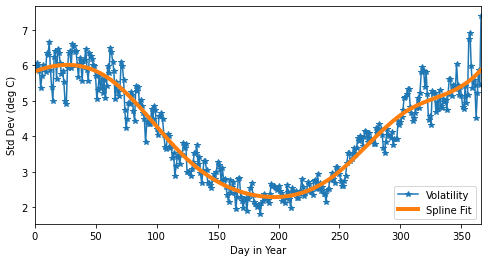

In [114]:
days = np.array(vol['std'].index)
T_std = np.array(vol['std'].values)
knots = 5

volatility = spline(knots, days, T_std)
plt.figure(figsize=(8,4))
plt.plot(days, T_std, marker='*',label='Volatility')
plt.plot(days, volatility, linewidth=4, label='Spline Fit')
plt.ylabel('Std Dev (deg C)')
plt.xlabel('Day in Year')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show() 

And our sinusoidal model for DAT:
#### $\bar{T}_t = 19.2 + 0.0000568t - 11.2472041 sin(\frac{2\pi}{365.25} t + 1.287855763)$
#### $\frac{d\bar{T}_t}{dt} = 0.0000568t - 11.2472041 (\frac{2\pi}{365.25}) cos(\frac{2\pi}{365.25} t + 1.287855763)$

<AxesSubplot:>

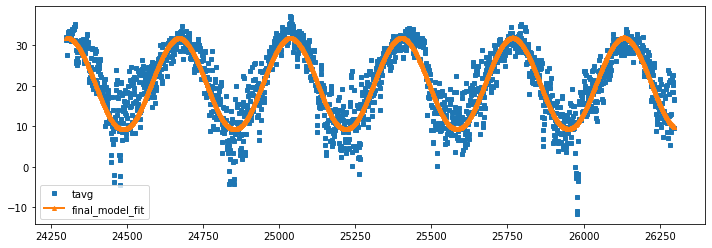

In [119]:
def T_model(x, a, b, alpha, theta):
    omega = 2*np.pi/365.25
    T = a + b*x + alpha*np.sin(omega*x + theta)
    return T
def dT_model(x, a, b, alpha, theta):
    omega=2*np.pi/365.25
    dT =  b + alpha*omega*np.cos(omega*x + theta)
    return dT
Tbar_params = [19.2, 5.68e-05, -11.2472041, 1.287855763]
temp_t['final_model_fit'] = T_model(temp_t.index, *Tbar_params)
    
temp_t[['tavg','final_model_fit']][-2000:].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )

Discretizing the OU dynamics for monte carlo simulation:
#### $T_{i+1} = T_i + \bar{T_i}' + 0.2921 (\bar{T_i} – T_i) + \sigma_t z_i$

In [129]:
def euler_step(row, kappa, M):
    """Function for euler scheme approximation step in 
    modified OH dynamics for temperature simulations
    Inputs: 
    - dataframe row with columns: T, Tbar, dTbar and vol
    - kappa: rate of mean reversion
    Output:
    - temp: simulated next day temperatures
    """
    if row['Tbar_shift'] != np.nan:
        T_i = row['Tbar']
    else:
        T_i = row['Tbar_shift']  
    T_det = T_i + row['dTbar']
    T_mrev =  kappa*(row['Tbar'] - T_i)
    sigma = row['vol']*np.random.randn(M)
    return T_det + T_mrev + sigma

def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, kappa=0.2921):
    """Monte Carlo simulation of temperature
    Inputs:
    - trading_dates: pandas DatetimeIndex from start to end dates
    - M: number of simulations
    - Tbar_params: parameters used for Tbar model
    - vol_model: fitted volatility model with days in year index
    - first_ord: first ordinal of fitted Tbar model
    Outputs:
    - mc_temps: DataFrame of all components individual components
    - mc_sims: DataFrame of all simulated temerpature paths
    """
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(datetime.toordinal)
      
    # Use Modified Ornstein-Uhlenbeck process with estimated parameters to simulate Tbar DAT 
    Tbars = T_model(trading_date-first_ord, *Tbar_params) 
    
    # Use derivative of modified OH process SDE to calculate change of Tbar
    dTbars = dT_model(trading_date-first_ord, *Tbar_params) 
    
    # Create DateFrame with thi
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])
    
    # Create columns for day in year
    mc_temps['day'] = mc_temps.index.dayofyear
    
    # Apply BSpline volatility model depending on day of year 
    mc_temps['vol'] = vol_model[mc_temps['day']-1]
    # Shift Tbar by one day (lagged Tbar series)
    mc_temps['Tbar_shift'] = mc_temps['Tbar'].shift(1)  
    
    # Apply Euler Step Pandas Function
    data = mc_temps.apply(euler_step, args=[kappa, M], axis=1)
    
    # Create final DataFrame of all simulations
    mc_sims = pd.DataFrame(data=[x for x in [y for y in data.values]], 
                 index=trading_dates,columns=range(1,M+1))
    
    return mc_temps, mc_sims

In [130]:
# define trading date range
no_sims = 5
trading_dates = pd.date_range(start='2022-09-01', end='2025-08-31', freq='D')
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord, no_sims)

In [131]:
mc_temps

,Tbar,dTbar,day,vol,Tbar_shift
2022-09-01,28.893491,-0.132625,244,2.852732,NaN
2022-09-02,28.759662,-0.135027,245,2.878299,28.893491
2022-09-03,28.623450,-0.137390,246,2.904484,28.759662
2022-09-04,28.484896,-0.139712,247,2.931263,28.623450
2022-09-05,28.344040,-0.141993,248,2.958612,28.484896
...,...,...,...,...,...
2025-08-27,29.557683,-0.120688,239,2.734265,29.677065
2025-08-28,29.435701,-0.123271,240,2.756722,29.557683
2025-08-29,29.311154,-0.125817,241,2.779793,29.435701
2025-08-30,29.184079,-0.128326,242,2.803482,29.311154


In [132]:
mc_sims

,1,2,3,4,5
2022-09-01,29.353035,30.717161,28.970877,27.077212,26.934743
2022-09-02,27.809606,28.054611,33.397780,29.033334,26.008387
2022-09-03,31.914574,27.266706,28.829629,24.608771,29.167632
2022-09-04,22.665312,21.893037,30.815825,29.576134,26.586000
2022-09-05,23.351008,26.719087,25.350491,25.012660,31.669092
...,...,...,...,...,...
2025-08-27,26.947310,28.567813,27.221598,31.741491,29.511677
2025-08-28,27.118588,28.439397,29.373320,29.331933,31.366452
2025-08-29,32.140179,37.405685,28.503863,25.680864,29.945668
2025-08-30,27.729745,32.604071,33.345076,24.951769,28.831577


#### Plotting a Single Simulation

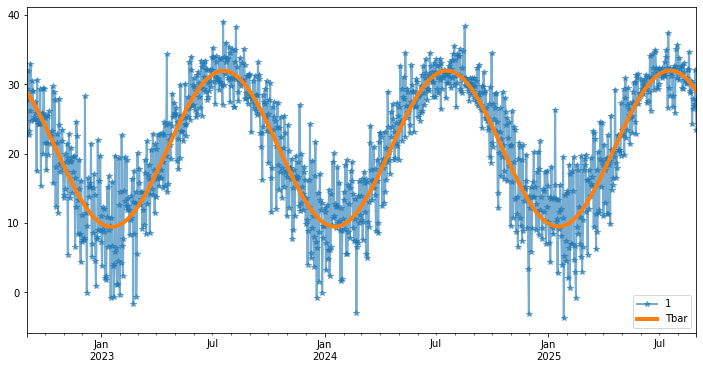

In [133]:
plt.figure(figsize=(12,6))
mc_sims[1].plot(alpha=0.6,linewidth=2, marker='*')
mc_temps["Tbar"].plot(linewidth=4)
plt.legend(loc='lower right')
plt.show()

### Temperature Distributions

Let’s finally observe the difference between our monte carlo temperature simulations distribution between the peaks of summer and winter days.

Here we simulate 10,000 temperatures on 1st July, 2023 for Summer and 1st Jan, 2023 for a representation of peak Winter temps and volatility.

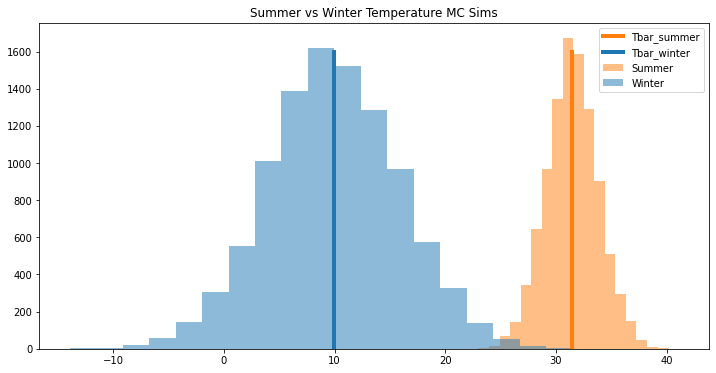

In [134]:
no_sims = 10000
trading_dates_summer = pd.date_range(start='2023-07-01', end='2023-07-01', freq='D')
mc_temps_summer, mc_sims_summer = monte_carlo_temp(trading_dates_summer, Tbar_params, volatility, first_ord, no_sims)

trading_dates_winter = pd.date_range(start='2023-01-01', end='2023-01-01', freq='D')
mc_temps_winter, mc_sims_winter = monte_carlo_temp(trading_dates_winter, Tbar_params, volatility, first_ord, no_sims)

plt.figure(figsize=(12,6))
plt.title('Winter vs Summer Temperature MC Sims')

Tbar_summer = mc_temps_summer.iloc[-1,:]['Tbar']
Tbar_winter = mc_temps_winter.iloc[-1,:]['Tbar']

plt.hist(mc_sims_summer.iloc[-1,:],bins=20, alpha=0.5, label='Summer', color='tab:orange')
plt.plot([Tbar_summer,Tbar_summer],[0,1600], linewidth=4, label='Tbar_summer', color='tab:orange')
plt.title('Summer vs Winter Temperature MC Sims')

plt.hist(mc_sims_winter.iloc[-1,:],bins=20, alpha=0.5, label='Winter', color='tab:blue')
plt.plot([Tbar_winter,Tbar_winter],[0,1600], linewidth=4, label='Tbar_winter', color='tab:blue')
plt.legend()
plt.show()

# Risk-Neutral Pricing of Temperature Derivatives

Temperature derivatives are incomplete market due in part to the fact the underlying (temperature) cannot be traded directly. Due to this, we must consider a market price of risk $\lambda$ to evaluate <b>unique</b> prices

We assume a constant market price for risk provided there is no real market to obtain prices. We assume further that we have a risk free asset with constant  interest rate $r$ and a contract that pays one unit of currency per degree Celsius. Therefore, under a martingale measure $\mathbb{Q}$ our OU dynamics looks like the following:

### $dT_t^{\mathbb{Q}}  = [ \frac{d\bar{T}_t}{dt} + k (\bar{T}_t-T_t) - \lambda \sigma_t ] dt + \sigma_t dW_t^{\mathbb{Q}} \implies$

### $ T_t = \bar{T}_t + (T_s-\bar{T}_s)e^{-\kappa(t-s)} - \lambda \int_{s}^{t}e^{-\kappa(t-u)}\sigma_u du +\int_{s}^{t}e^{-\kappa(t-u)}\sigma_u dW_u \implies$

### $ \mathbb{E}^{\mathbb{Q}}[T_t|F_s] = \mathbb{E}^{\mathbb{P}}[T_t|F_s] - \lambda \int_{s}^{t}e^{-\kappa(t-u)}\sigma_u du $

### $ \mathbb{Var}^{\mathbb{Q}}[T_t|F_s] = \int_{s}^{t}e^{-2\kappa(t-u)}\sigma^2_u du $

Provided volatility is constant within the interval of interest, the integrals above evaluate to:

### $ \mathbb{E}^{\mathbb{Q}}[T_t|F_s] = \mathbb{E}^{\mathbb{P}}[T_t|F_s] - \frac{\lambda \sigma_n}{\kappa} (1-e^{-\kappa(t-s)}) $

### $ \mathbb{Var}^{\mathbb{Q}}[T_t|F_s] = \frac{\sigma^2_n}{2\kappa} (1-e^{-2\kappa(t-s)}) $

### $ 0 \leq s \leq t \leq u \implies \mathbb{Cov}^{\mathbb{Q}}[T_tT_u|F_s] = e^{-\kappa(u-t)} \mathbb{Var}^{\mathbb{Q}}[T_t|F_s]$

### Black-Scholes Approach
Temperature derivatives traded on CME are with respect to reference temp of $18 C^{\circ} (65 F^{\circ})$
### $\xi = \alpha(DD-K)^+$
### $ DD = H_n =HDD^N = \sum_{n}^{N}(18-T_n)^+$
If the frequency of temperatures rising above the reference temp is near zero, this black scholes approach is applicable and can provide us a closed form solution to pricing temperature options.

### $\mathbb{P}(18-T_n)^+=0 \approx 0$

Because of this we can use a Gaussian OU process such that:
### $T_t \sim N(\mathbb{E}^{\mathbb{Q}}[T_t|F_s], \sqrt{\mathbb{Var}^{\mathbb{Q}}[T_t|F_s]})$
Therefore:
### $ DD = H_n = HDD^N = \sum_{n}^{N}(18-T_n)^+ \approx 18N-\sum_{n}^{N}T_n \implies$
### $\mu_t = \mathbb{E}^{\mathbb{Q}}[H_n|F_s] \approx 18N - \sum_{n}^{N}\mathbb{E}^{\mathbb{Q}}[T_t|F_s]$
### $\sigma^2_t = \mathbb{Var}^{\mathbb{Q}}[H_n|F_s] = \mathbb{Var}^{\mathbb{Q}}(\sum_{n}^{N}T_n) = \sum_{n}^{N}\mathbb{Var}^{\mathbb{Q}}T_n + 2 \sum_{n=1}^{N} \sum_{n<m}^{N}\mathbb{Cov}^{\mathbb{Q}}(T_n,T_m)$
References:
[1] Djehiche, Boualem, Alaton, Peter, and Stillberger, David. On modelling and pricing weather
derivatives. Applied Mathematical Finance, 9:1–20, 2002

### Note: As shown below, in Dallas, there is a significant number of temps above the $18 C^{\circ}$ reference temp during the heating degree periods (Dec-Feb).

In [161]:
trading_dates = pd.date_range(start='2022-12-01', end='2023-02-28', freq='D')
volatility = spline(5, days, T_std)
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord)

print('Probability P(max(18-Tn, 0) = 0): {0:1.1f}%'.format(len(mc_sims[mc_sims[1] >= 18])/len(mc_sims)*100))

Probability P(max(18-Tn, 0) = 0): 5.6%


It suggests that the pricing model may not be the most suitable for Dallas, TX, and we will need to investigate the differences more closely. Nevertheless, it's important to mention that this model could be suitable for cities like Chicago or New York in the north, considering the significantly harsher winters they experience.

In [158]:
def rn_mean(time_arr, vol_arr, Tbars, lamda, kappa):
    """Evaluate the risk neutral integral above for each segment of constant volatility
    Rectangular integration with step size of days
    """
    dt = 1/365.25
    N = len(time_arr)
    mean_intervals = -vol_arr*(1 - np.exp(-kappa*dt))/kappa
    return 18*N - (np.sum(Tbars) - lamda*np.sum(mean_intervals))

def rn_var(time_arr, vol_arr, kappa):
    """Evaluate the risk neutral integral above for each segment of constant volatility
    Rectangular integration with step size of days
    """
    dt = 1/365.25 
    var_arr = np.power(vol_arr,2) 
    var_intervals = var_arr/(2*kappa)*(1-np.exp(-2*kappa*dt))
    cov_sum = 0
    for i, ti in enumerate(time_arr):
        for j, tj in enumerate(time_arr):
            if j > i:
                cov_sum += np.exp(-kappa*(tj-ti)) * var_intervals[i]
    return np.sum(var_intervals) + 2*cov_sum

def risk_neutral(trading_dates, Tbar_params, vol_model, first_ord, lamda, kappa=0.2921):
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(datetime.toordinal)
  
    Tbars = T_model(trading_date-first_ord, *Tbar_params) 
    dTbars = dT_model(trading_date-first_ord, *Tbar_params) 
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])
    mc_temps['day'] = mc_temps.index.dayofyear
    mc_temps['vol'] = vol_model[mc_temps['day']-1]
    time_arr = np.array([i/365.25 for i in range(1,len(trading_dates)+1)])
    vol_arr = mc_temps['vol'].values
    mu_rn = rn_mean(time_arr, vol_arr, Tbars, lamda, kappa)
    var_rn = rn_var(time_arr, vol_arr, kappa)
    return mu_rn, var_rn

### Closed-form Solution
Fundamental theorem of asset pricing:
#### Call Option:
### $\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{Q}}[\frac{C_t}{B_t}|F_t] \implies C_t = B_t\mathbb{E}_{\mathbb{Q}}[\frac{C_t}{B_t}|F_t]$
### $C_t = B_t\mathbb{E}_{\mathbb{Q}}[\alpha(DD-K)^+] \implies \alpha e^{-r(T-t)} \int_{K}^{\infty}(x-K)f_{DD}(x)dx = \alpha e^{-r(T-t)} \big( (\mu_t-K)\Phi(-Z_t)+\frac{\sigma_t}{\sqrt{2\pi}}e^{\frac{-Z^2_t}{2}} \big)$
where: $Z_t = \frac{K-\mu_t}{\sigma_t}$ and $\Phi$ is CDF of Normal Dist.
#### Put Option:
### $P_t = B_t\mathbb{E}_{\mathbb{Q}}[\alpha(K-DD)^+] \implies \alpha e^{-r(T-t)} \int_{0}^{K}(K-x)f_{DD}(x)dx = \alpha e^{-r(T-t)} \big( (K-\mu_t)(\Phi(Z_t)\Phi(-\frac{\mu_t}{\sigma_t}))+\frac{\sigma_t}{\sqrt{2\pi}}(e^{\frac{-Z^2_t}{2}}-e^{\frac{-{\mu_t}^2_t}{2\sigma^2_t}}) \big)$

In [162]:
def winter_option(trading_dates, r, alpha, K, tau, opt='c', lamda=0.0):
    """Evaluate the fair value of temperature option in winter
    Based on heating degree days only if the physical probability that 
    the average temperature exceeds the Tref (18 degC) is close to 0 
    """
    mu_rn, var_rn = risk_neutral(trading_dates, Tbar_params, volatility, first_ord, lamda)
    disc = np.exp(-r*tau)
    vol_rn = np.sqrt(var_rn)
    zt = (K - mu_rn)/vol_rn
    exp = np.exp(-zt**2/2)
    if opt == 'c':
        return alpha*disc*((mu_rn - K)*stats.norm.cdf(-zt) + vol_rn*exp/np.sqrt(2*np.pi))
    else:
        exp2 = np.exp(-mu_rn**2/(2*vol_rn**2))
        return alpha*disc*((K - mu_rn)*(stats.norm.cdf(zt) - stats.norm.cdf(-mu_rn/vol_rn)) +
                           vol_rn/np.sqrt(2*np.pi)*(exp-exp2))


trading_dates = pd.date_range(start='2022-12-01', end='2023-02-28', freq='D')
r=0.05
K=500
alpha=2500

def years_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)/365.25

start = '2022-12-01'
end = '2023-02-28'

tau = years_between(start, end)

print('Start Valuation Date:', start, 
      '\nEnd of Contract Date:', end, 
      '\nYears between Dates :', round(tau,3))

print('Call Price: ', round(winter_option(trading_dates, r, alpha, K, tau, 'c'),2))
print('Put Price : ', round(winter_option(trading_dates, r, alpha, K, tau, 'p'),2))

Start Valuation Date: 2022-12-01 
End of Contract Date: 2023-02-28 
Years between Dates : 0.244
Call Price:  415890.67
Put Price :  0.0


### Monte Carlo Valuations
### $ DD = H_n =HDD^N = \sum_{n}^{N}(18-T_n)^+$
For each simulation $m \in M$:
### $C_t = e^{-r\tau}\frac{1}{M}\sum_{m=1}^{M}[\alpha(DD_m-K)^+] $

In [163]:
# define trading date range
trading_dates = pd.date_range(start='2022-12-01', end='2023-02-28', freq='D')
no_sims = 10000
vol_model = spline(5, days, T_std)

def temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, opt='c'):
    "Evaluates the price of a temperature call option"
    mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord, no_sims)
    N, M = np.shape(mc_sims)
    mc_arr = mc_sims.values
    DD = np.sum(np.maximum(18-mc_arr,0), axis=0)
    if opt == 'c':
        CT = alpha*np.maximum(DD-K,0)
    else:
        CT = alpha*np.maximum(K-DD,0)
    C0 = np.exp(-r*tau)*np.sum(CT)/M
    sigma = np.sqrt( np.sum( (np.exp(-r*tau)*CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    return C0, SE

call = np.round(temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, 'c'),2)
put = np.round(temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, 'p'),2)
print('Call Price: {0} +/- {1} (2se)'.format(call[0], call[1]*2))
print('Put Price : {0} +/- {1} (2se)'.format(put[0], put[1]*2))

Call Price: 478653.55 +/- 2480.86 (2se)
Put Price : 0.0 +/- 0.0 (2se)


Comparing Methods:

In [153]:
strikes = np.arange(500,900,20)
data = np.zeros(shape=(len(strikes),4))
for i, strike in enumerate(strikes):
    data[i,0] = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, 'c')[0]
    data[i,1] = winter_option(trading_dates, r, alpha, strike, tau, 'c')
    data[i,2] = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, 'p')[0]
    data[i,3] = winter_option(trading_dates, r, alpha, strike, tau, 'p')

df = pd.DataFrame({'MC Call': data[:, 0], 'BSA Call': data[:, 1], 'MC Put': data[:, 2], 'BSA Put': data[:, 3]})
df.index = strikes

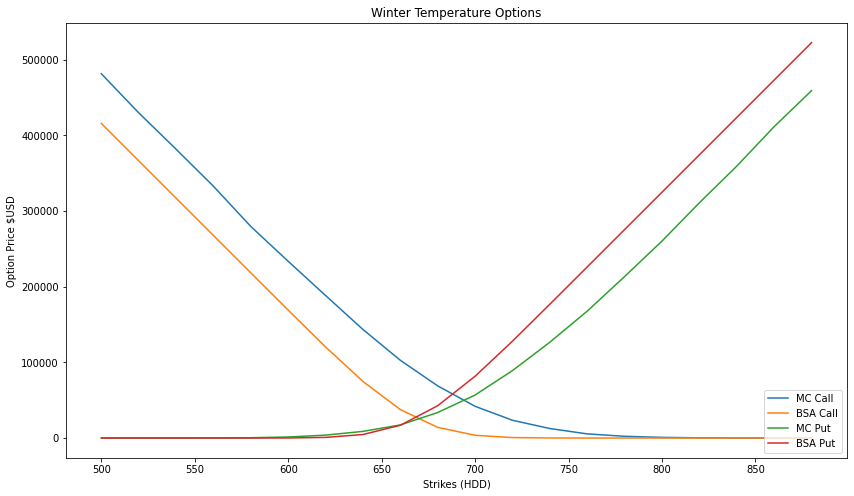

In [164]:
plt.figure(figsize=(14,8))
plt.plot(df)
plt.title('Winter Temperature Options')
plt.ylabel('Option Price $USD')
plt.xlabel('Strikes (HDD)')
plt.legend(df.columns, loc=4)
plt.show()

#### Concluding Statements

As anticipated, there is a substantial deviation between the black scholes approach and the monte carlo approach. It was expected that the black scholes method would overestimate the price due to its derivation assuming a negligible probability of temperatures moving above the reference temperature. However, the deviations below the reference temperature were much greater in the monte carlo simulation, despite the lower number of temperatures below the reference temperature, resulting in fewer but larger $𝐷𝐷𝑚−𝐾$ values. It is worth noting that temperature, being an underlying factor, cannot be traded directly, so a risk-neutral model is not feasible without making strong assumptions, as we did with the constant risk price.

Looking ahead, there are several measures we can take to enhance this pricing model:

<ol>
    <li> Incorporate machine learning techniques to learn the option pricing function directly from market data to further advise our theoretical model.
    <li> Optimize the number of knots in Blspine interpolation of volatility.
    <li> Incorporate Caps in the contract
    <li> Consider jump processes in modeling temperature volatility
     


 